In [1]:
import sys
import os

# Add your project root to sys.path (adjust the path below)
project_root = '/work/pi_shenoy_umass_edu/hshastri/FMaaS-motivation/timeseries/amazon-chronos/src'  # the folder containing 'momentfm'
if project_root not in sys.path:
    sys.path.insert(0, project_root)


In [ ]:

from torch.utils.data import DataLoader
from momentfm.data.classification_dataset import ClassificationDataset
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from typing import Tuple

import torch
from torch import nn
import os
import random
from argparse import Namespace
from typing import NamedTuple

import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pandas as pd
import torch
from chronos import ChronosPipeline



/home/hshastri_umass_edu/.conda/envs/amazon-chronos/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
train_dataset = ClassificationDataset(data_split='train')
test_dataset = ClassificationDataset(data_split='test')
print(test_dataset)

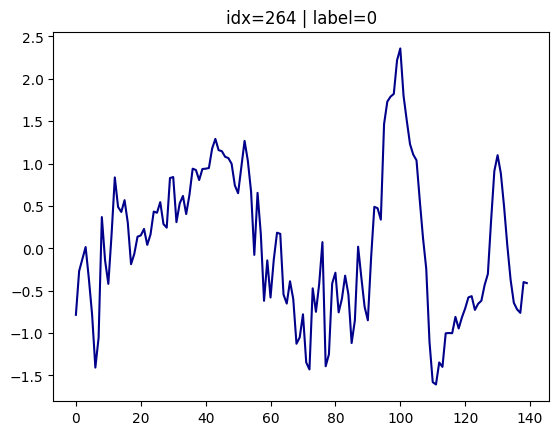

In [4]:
idx = np.random.randint(0, len(train_dataset))
heartbeat_start = np.argmax(train_dataset[idx][1])
heartbeat = train_dataset[idx][0].squeeze()[heartbeat_start:]
label = train_dataset[idx][2]
plt.plot(heartbeat, c='darkblue')
plt.title(f"idx={idx} | label={label}")
plt.show()

In [5]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=False, drop_last=False)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, drop_last=False)

In [6]:
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-large",
    device_map="cuda",
    torch_dtype=torch.bfloat16,)

In [7]:
def get_embedding(pipeline, dataloader):
    embeddings, labels = [], []
    with torch.no_grad():
        for batch_x, batch_masks, batch_labels in tqdm(dataloader, total=len(dataloader)):
            batch_x= batch_x.squeeze(1)
            output, tokenizer_state = pipeline.embed(batch_x)

            embedding = output.mean(dim=1)  # pooled to shape (batch_size, 1024)

            embeddings.append(embedding.detach().to(torch.float32).cpu().numpy())
            labels.append(batch_labels)        

    embeddings, labels = np.concatenate(embeddings), np.concatenate(labels)
    return embeddings, labels

In [8]:
# model.to("cuda").float()

train_embeddings, train_labels = get_embedding(pipeline, train_dataloader)
test_embeddings, test_labels = get_embedding(pipeline, test_dataloader)

print(train_embeddings.shape, train_labels.shape)
print(test_embeddings.shape, test_labels.shape)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [11:04<00:00,  9.36s/it]

(500, 1024) (500,)
(4500, 1024) (4500,)


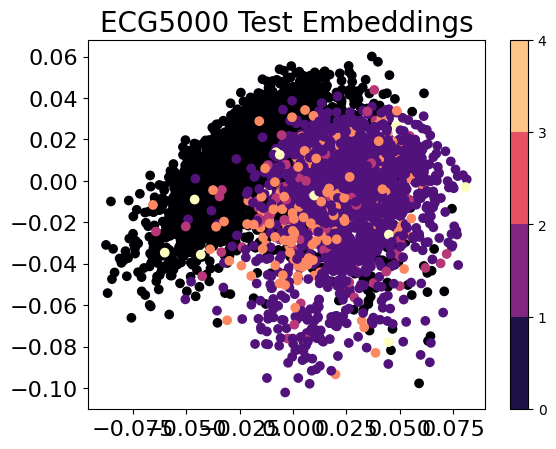

In [9]:
test_embeddings_manifold = PCA(n_components=2).fit_transform(test_embeddings) 

plt.title(f"ECG5000 Test Embeddings", fontsize=20)
plt.scatter(
    test_embeddings_manifold[:, 0], 
    test_embeddings_manifold[:, 1],
    c=test_labels.squeeze(),
    cmap='magma'
)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.colorbar(
    boundaries=np.arange(
    min(test_labels),
    max(test_labels)+1, 1)
)
plt.show()

In [10]:
from momentfm.models.statistical_classifiers import fit_svm

clf = fit_svm(features=train_embeddings, y=train_labels)

y_pred_train = clf.predict(train_embeddings)
y_pred_test = clf.predict(test_embeddings)
train_accuracy = clf.score(train_embeddings, train_labels)
test_accuracy = clf.score(test_embeddings, test_labels)


/home/hshastri_umass_edu/.conda/envs/amazon-chronos/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


In [11]:
print(y_pred_test)
print(test_labels)

print(f"Train accuracy: {train_accuracy:.2f}")
print(f"Test accuracy: {test_accuracy:.2f}")

[0 0 0 ... 1 1 3]
[0 0 0 ... 1 1 1]
Train accuracy: 0.99
Test accuracy: 0.93


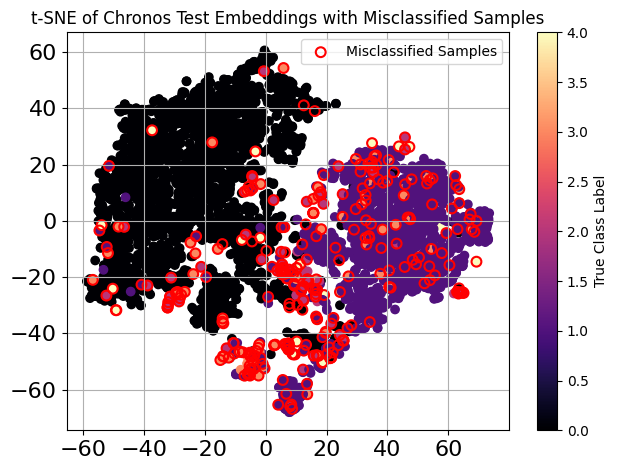

In [12]:
# # Step 1: Combine embeddings and labels
# all_embeddings = np.concatenate([train_embeddings, test_embeddings])
# all_labels = np.concatenate([train_labels, test_labels])

# # Step 2: Global test indices
# n_train = len(train_embeddings)
# test_indices_global = np.arange(n_train, n_train + len(test_embeddings))

# # # Step 3: Run PCA
# pca = PCA(n_components=2)
# embeddings_2d = pca.fit_transform(test_embeddings)

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
embeddings_2d = tsne.fit_transform(test_embeddings)

# Step 2: Misclassified indices
y_pred_test = clf.predict(test_embeddings)
misclassified_indices = np.where(y_pred_test != test_labels)[0]

# Step 3: Plot

plt.title("t-SNE of Chronos Test Embeddings with Misclassified Samples")
scatter=plt.scatter(
    embeddings_2d[:, 0], 
    embeddings_2d[:, 1],
    c=test_labels.squeeze(),
    cmap='magma'
)

# Highlight misclassified samples with red rings
plt.scatter(
    embeddings_2d[misclassified_indices, 0],
    embeddings_2d[misclassified_indices, 1],
    facecolors='none',
    edgecolors='red',
    s=50,
    linewidths=1.5,
    label="Misclassified Samples"
)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend()
plt.colorbar(scatter, label="True Class Label")
plt.grid(True)
plt.tight_layout()
plt.show()
